In [16]:
import numpy as np
import pandas as pd

from astropy.time import Time, TimeDelta
from astropy.coordinates import EarthLocation
from astropy import units as u
from astroplan import (FixedTarget, Observer, 
                       AltitudeConstraint, AtNightConstraint, 
                       MoonSeparationConstraint)

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
from astropy.utils.iers import IERS_A, IERS_A_URL
from astropy.utils.data import download_file
from datetime import datetime
import locale
locale.setlocale(locale.LC_ALL, 'fr_FR.UTF-8')
from astroplan import download_IERS_A

On définit une fonction contraintes, basé sur les librairies astropy et astroplan, qui nous permet de connaître les dates auxquelles il est possible d'observer une certaine phase de notre étoile en fonction de contraintes que l'on souhaite imposer : 

    -Il fait nuit    
    -L'étoile est à un angle supérieur à 30° de l'horizon    
    -L'étoile est à une distance angulaire supérieure à 30° de la lune

On entre les coordonnées de l'observatoire (New mexico skies), ainsi que le nom de l'étoile que l'on souhaite observer, puis l'on crée un tableau au format Time qui contient les 'amount' prochaines dates auxquelles l'étoile est aux différentes phases demandées. On vérifie en même temps que les contraintes soient respectées.
Si les contraintes sont respectées, la date est conservée. Sinon, elle est supprimée.
On renvoit un tableau au format DataFrame qui contient des colonnes correspondant aux différentes phases que l'on souhaite observer, et pour lesquelles on a une succession de dates d'observation possible.

In [17]:
def constraintes(amount, minimum, periode, phases, altitude, distance_lune) :
    
    #On définit les données relatives à l'observatoire et à notre étoile
    T5 = EarthLocation(lat = 32.9 * u.deg, lon = -105.5 * u.deg, height = 2225 * u.m)
    observatoire = Observer(location = T5, name = "T5")
    target = FixedTarget.from_name("DU BOO")
    
    #On définit nos contraintes
    constraints = [AtNightConstraint.twilight_astronomical(),
                  MoonSeparationConstraint(min = distance_lune *u.deg),
                  AltitudeConstraint(min = altitude * u.deg)]
    
    #On convertit les entrée au format Time
    start_min = Time(minimum, format = 'jd', scale = 'ut1')
    period = TimeDelta(periode, format = 'jd')
    
    #On change d'échelle pour passer en utc de puis ut1
    #iers_a_file = download_file(IERS_A_URL, cache=True)  
    iers_a = download_IERS_A()                  
    start_min.delta_ut1_utc = start_min.get_delta_ut1_utc(iers_a)   
    start_min.utc
    
    #On crée un tableau vide au format Time, et un tableau correspondant qui contiendra l'information
    #sur les contraintes
    time = Time(np.ones((amount, len(phases))), format = 'jd')
    ok = np.zeros_like(time)
    
    #On vérifie les contraintes
    for n in range (amount) :
        time[n] = start_min + periode * (phases + n)
        
        ok[n] = np.logical_and(constraints[0](observatoire, target, times = time[n]) == True, 
                np.logical_and(constraints[1](observatoire, target, times = time[n]) == True,
                               constraints[2](observatoire, target, times = time[n]) == True))
    
    #On se replace à l'heure = UTC - 7 si on est avant la date du changement d'heure au nouveau-mexique
    #Sinon, on se place à UTC - 6
    dst_nm = Time(datetime(2000, 3, 8, 2, 0, 0), format="datetime", scale = "utc")
    time = time - 7 * u.hour
    
    mask = np.where(time >= dst_nm)
    time[mask] = time[mask] + 1*u.hour
    
    #On extrait un array de notre tableau time dans un format de dates jour-mois Heure minute seconde
    #mis en forme pour un affichage sous latex (suppression de l'espace avant le deux-points)
    time_obs = time.strftime('%d %b $%H{:}%M{:}%S$')
    time_obs = time.iso
    
    #On transforme l'array en un dataFrame
    df = pd.DataFrame(data=time_obs, columns=phases)
    
    #On supprime les entrées la où les contraintes ne sont pas respectées    
    df = df.where(ok != False)
    
    return df
    


In [11]:
a = Time(datetime(2000, 3, 8, 2, 0, 0), format="datetime", scale = "utc")
print(a.iso)

2000-03-08 02:00:00.000


Afin de déterminer les phases que l'on souhaite observer, on utilise les données disponible sur [le site de l'université de strasbourg]('http://cdsarc.u-strasbg.fr/viz-bin/vizExec/Vgraph?I/239/70240&P=1.0558882&P=1.0558882')
On trace un graphique de ces données, que l'on décale afin de placer le début de la période au milieu du minimum principal de luminosité. On place ensuite les 15 points d'observations, d'abord en séparant uniformément la période, puis en ajustant afin d'avoir des points coincidant avec les maximas et minimas.
On a alors la liste des phases que l'on souhaite observer

In [12]:
lum = pd.read_csv('data/luminosite', delimiter = ' ', skiprows = 6, header = None,
                   names = ['phase', '', 'luminosite', 'erreur'])
lum.head()

,phase,,luminosite,erreur
0,0.239611,NaN,8.7616,0.018
1,0.582669,NaN,8.6570,0.017
2,0.596250,NaN,8.6454,0.017
3,0.666863,NaN,8.5992,0.015
4,0.279503,NaN,8.7985,0.012


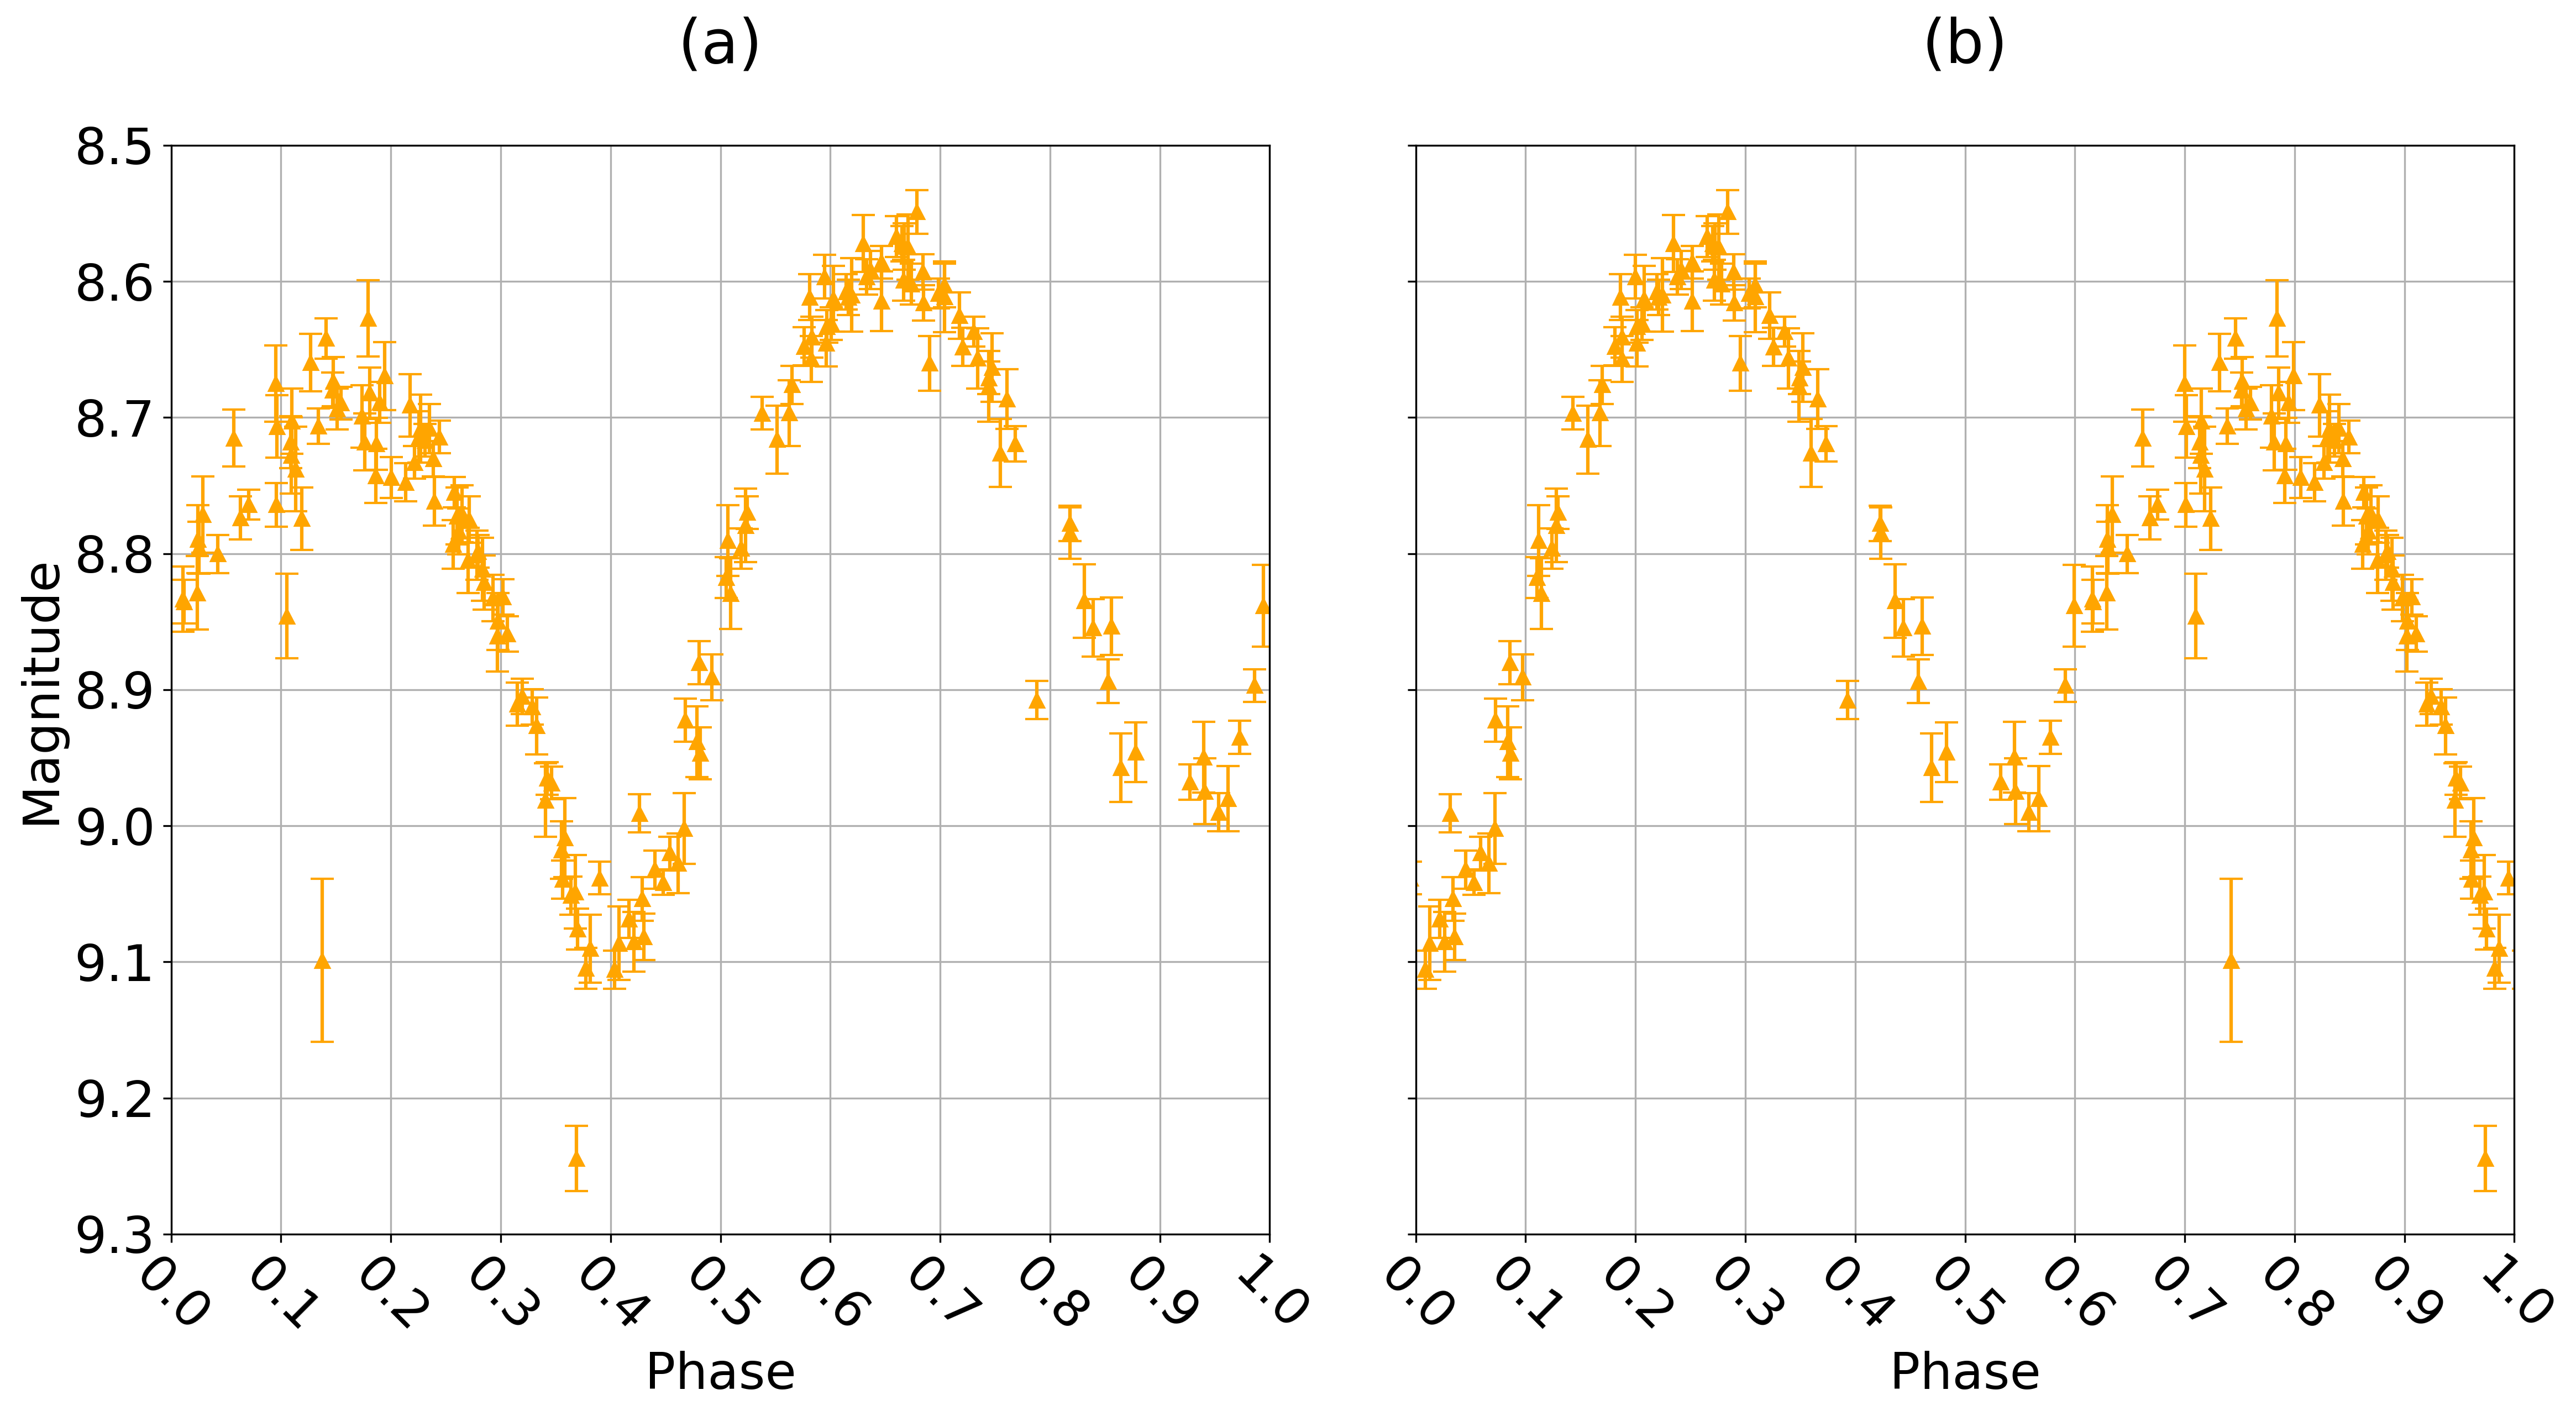

In [13]:

fig, ax = plt.subplots(1, 2, dpi = 300, figsize = (16, 9), sharey = True)

xticks = np.around(np.linspace(0, 1, 11), 1)

ax[0].set_title('(a)\n')

ax[0].errorbar(lum['phase'], lum['luminosite'], fmt = '^', yerr = lum['erreur'],
            capsize = 5, c = 'orange')

ax[0].set_xticks(xticks)
ax[0].set_xticklabels(xticks, rotation = -45)
ax[0].grid(which = 'both')

ax[0].set_xlim(0, 1)
ax[0].set_xlabel('Phase')

ax[0].set_ylim(8.5, 9.3)
ax[0].set_ylabel('Magnitude')
ax[0].invert_yaxis()


ax[1].set_title('(b)\n')

ax[1].errorbar(lum['phase'] + (1- 0.395), lum['luminosite'], fmt = '^', yerr = lum['erreur'],
            capsize = 5,  c ='orange')
ax[1].errorbar(lum['phase'] - 0.395, lum['luminosite'], fmt = '^', yerr = lum['erreur'],
            capsize = 5, c = 'orange')

ax[1].set_xticks(xticks)
ax[1].set_xticklabels(xticks, rotation = -45)
ax[1].grid(which = 'both')

ax[1].set_xlim(0, 1)
ax[1].set_xlabel('Phase')

ax[1].set_ylim(8.5, 9.3)
ax[1].invert_yaxis()

fig.tight_layout()

fig.savefig('figures/cds_luminosite_centree.png')

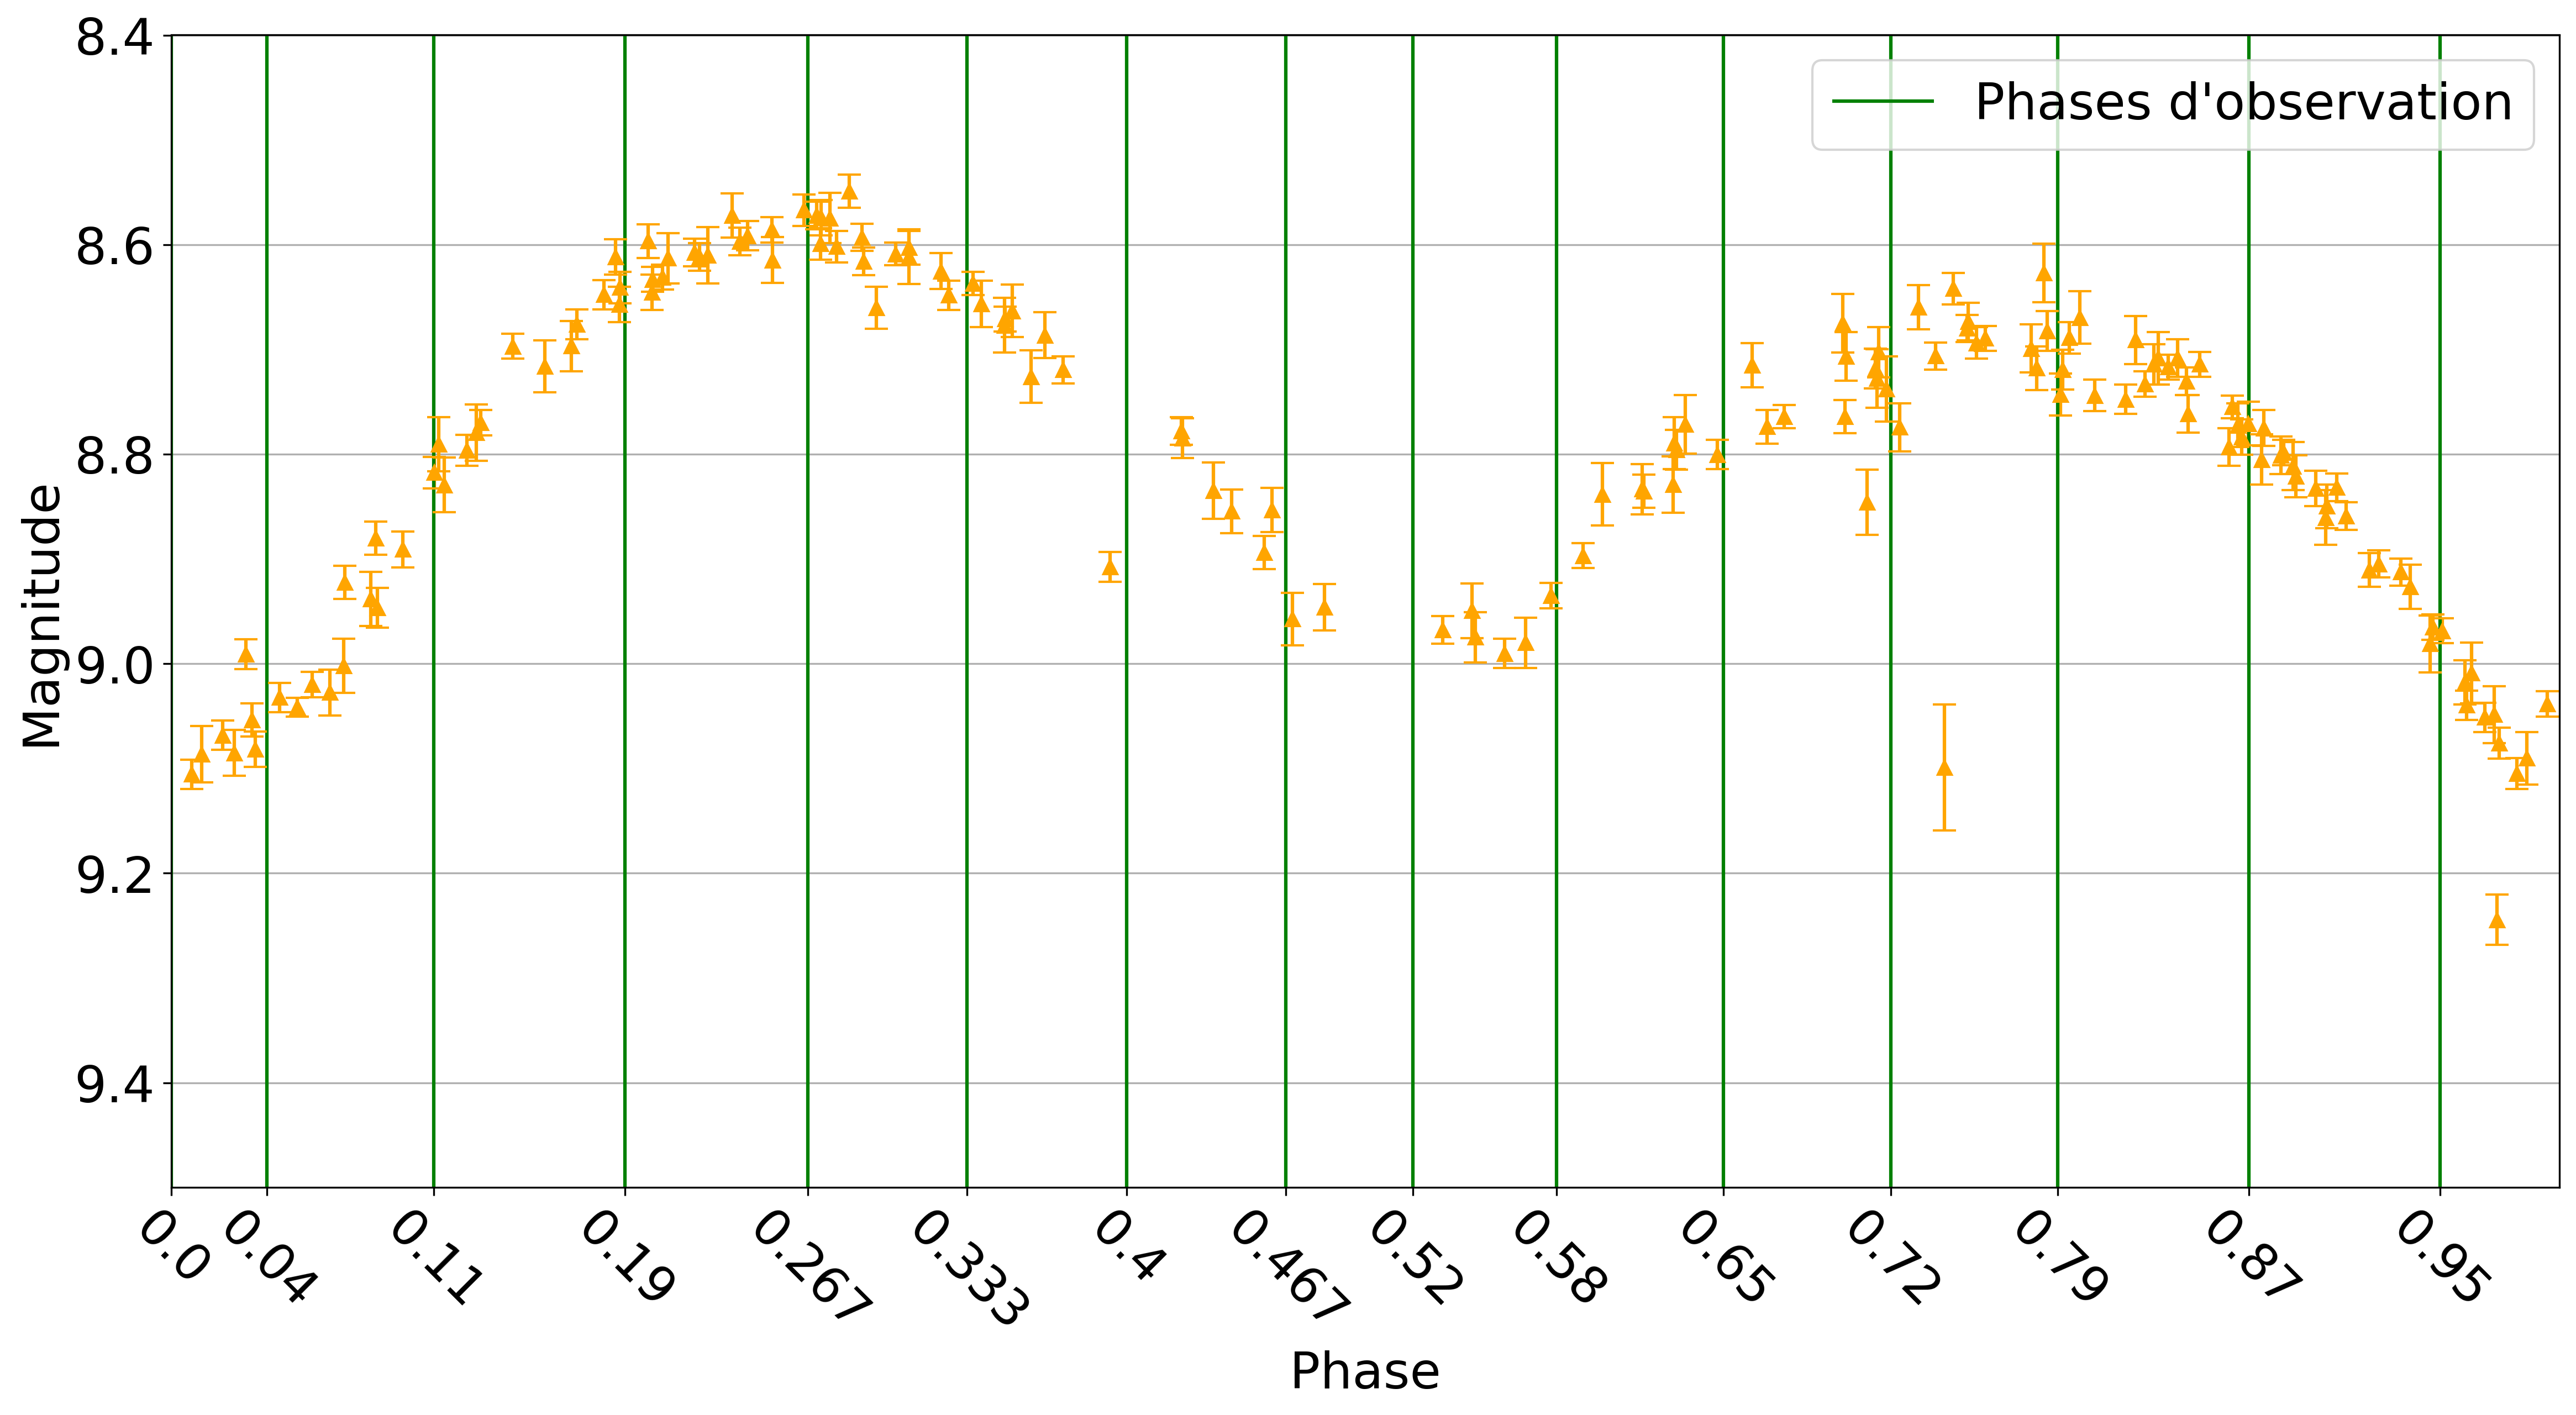

In [14]:

phases = np.linspace(0, 1, 16)
phases[-8:] = [0.52 , 0.58, 0.65 ,0.72, 0.79, 0.87, 0.95, 1.0]
phases[:4] = [0, 0.04, 0.11, 0.19]
phases = phases[:-1]


fig, ax = plt.subplots(1, 1, dpi = 300, figsize = (16, 9))




ax.errorbar(lum['phase']+ (1 - 0.395), lum['luminosite'], fmt = '^', yerr = lum['erreur'],
            capsize = 5,  c ='orange')
ax.errorbar(lum['phase'] - 0.395, lum['luminosite'], fmt = '^', yerr = lum['erreur'],
            capsize = 5, c = 'orange')
ax.vlines(phases, 8.4, 9.5, color = 'g', label = 'Phases d\'observation')

"""
y = np.linspace(8.4, 9.5, 50)
x = np.ones_like(y)
ax.errorbar(x, y, xerr = 0.0104/2, color = 'g', fmt = 'none', capsize = 5, label = 'Phases d\'observation')
for n in range(len(phases)):
    x = np.ones_like(y)*phases[n]
    ax.errorbar(x, y, xerr = 0.0104/2, color = 'g', fmt = 'none', capsize = 5)
"""




ax.set_xlim(0, 1)
ax.set_xlabel('Phase')

ax.set_ylim(8.4, 9.5)
ax.set_ylabel('Magnitude')
ax.invert_yaxis()

ax.set_xticks(phases)
ax.set_xticklabels(np.around(phases, 3), rotation = -45)
ax.grid()

ax.legend()

fig.tight_layout()

fig.savefig('figures/cds_luminosite_centree_phases')


On initialise une variable contenant la période de l'étoile variable, ainsi qu'une variable contenant la date en jour julien correspondant au milieu de son minimum de luminosité, d'après l'éphéméride [disponible ici]('https://www.aavso.org/vsx/index.php?view=detail.ephemeris&nolayout=1&oid=4446' "aavso")
De plus, on crée un array contenant les différentes phases de l'étoile que l'on souhaite observer. Il faut noter que le début de la période est ici choisie en le minimum de luminosité de l'étoile.

On envoie alors ces données dans notre fonction contraintes(), qui nous renvoie un tableau au format DataFrame, contenant une liste de dates pour lesquelles les contraintes que l'on a choisies sont respectées.
Attention les dates sont à l'heure locale ! UTC - 7

In [23]:
minimum = 2458893.438
periode = 1.0558882
altitude_min = 30
distance_lune = 30

#On avance dans le temps jusqu'à ce que la date indiqué pour le minimum soit postérieure à la date
#actuelle
today = Time(datetime.utcnow(), format = 'datetime')
while minimum < today.jd -3 :
    minimum = minimum + periode

dates = constraintes(50, minimum, periode, phases, altitude_min, distance_lune)
dates.head()

,0.000000,0.040000,0.110000,0.190000,0.266667,0.333333,0.400000,0.466667,0.520000,0.580000,0.650000,0.720000,0.790000,0.870000,0.950000
0,2020-04-01 04:52:16.748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-01 23:07:01.441,2020-04-02 00:53:27.453,2020-04-02 02:55:05.752,2020-04-02 04:56:44.051
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-02 22:41:04.170,2020-04-03 00:27:30.182,2020-04-03 02:13:56.194,2020-04-03 04:15:34.493,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-03 22:15:06.899,2020-04-04 00:01:32.911,2020-04-04 01:47:58.923,2020-04-04 03:34:24.935,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-04 22:04:21.916,2020-04-04 23:35:35.641,2020-04-05 01:22:01.653,2020-04-05 03:08:27.665,2020-04-05 04:54:53.676,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-05 22:03:45.125,2020-04-05 23:24:50.658,2020-04-06 00:56:04.383,2020-04-06 02:42:30.394,2020-04-06 04:28:56.406,NaN,NaN,NaN


Il y a beaucoup de trous dans ce tableau. La cellule suivante permet de le nettoyer, et de supprimer toutes les entrées nulles.

In [24]:
data = []
for i,phase in enumerate(list(dates)) :
    data.append(dates[phase].dropna().values.tolist())

dates_sort = pd.DataFrame(data = data, index = np.around(phases, 3))


dates_sort = dates_sort.transpose()
dates_sort


,0.000,0.040,0.110,0.190,0.267,0.333,0.400,0.467,0.520,0.580,0.650,0.720,0.790,0.870,0.950
0,2020-04-01 04:52:16.748,2020-04-13 21:58:50.795,2020-04-11 21:04:19.325,2020-04-10 21:45:28.883,2020-04-09 22:21:34.345,2020-04-07 21:21:58.777,2020-04-06 21:42:51.951,2020-04-05 22:03:45.125,2020-04-04 22:04:21.916,2020-04-03 22:15:06.899,2020-04-02 22:41:04.170,2020-04-01 23:07:01.441,2020-04-02 00:53:27.453,2020-04-02 02:55:05.752,2020-04-02 04:56:44.051
1,2020-04-13 20:58:01.645,2020-04-14 23:19:19.535,2020-04-12 22:24:48.066,2020-04-11 23:05:57.624,2020-04-10 23:42:03.086,2020-04-08 22:42:27.519,2020-04-07 23:03:20.693,2020-04-06 23:24:13.867,2020-04-05 23:24:50.658,2020-04-04 23:35:35.641,2020-04-04 00:01:32.911,2020-04-03 00:27:30.182,2020-04-03 02:13:56.194,2020-04-03 04:15:34.493,2020-04-14 21:02:28.949
2,2020-04-14 22:18:30.386,2020-04-16 00:39:48.276,2020-04-13 23:45:16.807,2020-04-13 00:26:26.365,2020-04-12 01:02:31.827,2020-04-10 00:02:56.261,2020-04-09 00:23:49.435,2020-04-08 00:44:42.609,2020-04-07 00:45:19.400,2020-04-06 00:56:04.383,2020-04-05 01:22:01.653,2020-04-04 01:47:58.923,2020-04-04 03:34:24.935,2020-04-16 21:41:48.131,2020-04-15 22:22:57.690
3,2020-04-15 23:38:59.127,2020-04-17 02:00:17.017,2020-04-15 01:05:45.547,2020-04-14 01:46:55.106,2020-04-13 02:23:00.568,2020-04-11 01:23:25.002,2020-04-10 01:44:18.177,2020-04-09 02:05:11.351,2020-04-08 02:05:48.142,2020-04-07 02:16:33.125,2020-04-06 02:42:30.394,2020-04-05 03:08:27.665,2020-04-05 04:54:53.676,2020-04-17 23:02:16.872,2020-04-16 23:43:26.430
4,2020-04-17 00:59:27.867,2020-04-18 03:20:45.758,2020-04-16 02:26:14.288,2020-04-15 03:07:23.847,2020-04-14 03:43:29.309,2020-04-12 02:43:53.744,2020-04-11 03:04:46.918,2020-04-10 03:25:40.093,2020-04-09 03:26:16.884,2020-04-08 03:37:01.867,2020-04-07 04:02:59.136,2020-04-06 04:28:56.406,2020-04-18 22:21:07.314,2020-04-19 00:22:45.613,2020-04-18 01:03:55.171
5,2020-04-18 02:19:56.608,2020-04-19 04:41:14.499,2020-04-17 03:46:43.029,2020-04-16 04:27:52.587,2020-04-15 05:03:58.050,2020-04-13 04:04:22.484,2020-04-12 04:25:15.660,2020-04-11 04:46:08.834,2020-04-10 04:46:45.626,2020-04-09 04:57:30.609,2020-04-20 21:29:12.772,2020-04-19 21:55:10.043,2020-04-19 23:41:36.055,2020-04-20 01:43:14.354,2020-04-19 02:24:23.912
6,2020-04-19 03:40:25.349,2020-05-02 22:07:28.131,2020-05-01 22:33:25.401,2020-04-29 21:54:06.219,2020-04-28 22:30:11.681,2020-04-26 21:30:36.116,2020-04-25 21:51:29.292,2020-04-24 22:12:22.467,2020-04-23 22:12:59.259,2020-04-22 22:23:44.242,2020-04-21 22:49:41.513,2020-04-20 23:15:38.784,2020-04-21 01:02:04.796,2020-04-21 03:03:43.095,2020-04-20 03:44:52.653
7,2020-05-03 22:27:07.723,2020-05-03 23:27:56.872,2020-05-02 23:53:54.143,2020-04-30 23:14:34.959,2020-04-29 23:50:40.422,2020-04-27 22:51:04.857,2020-04-26 23:11:58.032,2020-04-25 23:32:51.208,2020-04-24 23:33:28.000,2020-04-23 23:44:12.983,2020-04-23 00:10:10.254,2020-04-22 00:36:07.525,2020-04-22 02:22:33.537,2020-04-22 04:24:11.836,2020-05-04 22:31:35.027
8,2020-05-04 23:47:36.464,2020-05-05 00:48:25.614,2020-05-04 01:14:22.884,2020-05-02 00:35:03.701,2020-05-01 01:11:09.163,2020-04-29 00:11:33.597,2020-04-28 00:32:26.773,2020-04-27 00:53:19.948,2020-04-26 00:53:56.740,2020-04-25 01:04:41.724,2020-04-24 01:30:38.995,2020-04-23 01:56:36.266,2020-04-23 03:43:02.278,2020-05-05 21:50:25.470,2020-05-05 23:52:03.769
9,2020-05-06 01:08:05.206,2020-05-06 02:08:54.356,2020-05-05 02:34:51.626,2020-05-03 01:55:32.442,2020-05-02 02:31:37.904,2020-04-30 01:32:02.338,2020-04-29 01:52:55.513,2020-04-28 02:13:48.689,2020-04-27 02:14:25.481,2020-04-26 02:25:10.465,2020-04-25 02:51:07.736,2020-04-24 03:17:05.007,2020-05-07 22:29:44.653,2020-05-06 23:10:54.211,2020-05-07 01:12:32.510


 On exporte ensuite les premières colonnes du tableau au format txt, pour pouvoir ensuite l'intégrer facilement dans latex

In [25]:
#dates_sort.to_latex('data/dates_30_latex.txt', columns = [0,1,2], header = ['1', '2', '3'], escape = False)

Cependant, si l'on souhaite ne garder qu'en premier choix, que les dates pour lesquelles l'étoile est à une altitude supérieure à 70 ° on demande :

In [21]:
dates_70 = constraintes(50, minimum, periode, phases, 70, distance_lune)
dates_70.head()

,0.000000,0.040000,0.110000,0.190000,0.266667,0.333333,0.400000,0.466667,0.520000,0.580000,0.650000,0.720000,0.790000,0.870000,0.950000
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-02 02:55:05.752,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-03 02:13:56.194,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-04 01:47:58.923,2020-04-04 03:34:24.935,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-05 01:22:01.653,2020-04-05 03:08:27.665,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-06 00:56:04.383,2020-04-06 02:42:30.394,NaN,NaN,NaN,NaN


In [22]:
data = []
for i,phase in enumerate(list(dates_70)) :
    data.append(dates_70[phase].dropna().values.tolist())

dates_sort_70 = pd.DataFrame(data = data, index = np.around(phases, 3))

#dates_sort_70 = dates_sort_70.transpose()
dates_sort_70

,0,1,2,3,4,5,6,7,8
0.000,2020-04-17 00:59:27.867,2020-04-18 02:19:56.608,2020-05-04 23:47:36.464,2020-05-06 01:08:05.206,2020-05-22 22:35:45.058,None,None,None,None
0.040,2020-04-16 00:39:48.276,2020-04-17 02:00:17.017,2020-05-03 23:27:56.872,2020-05-05 00:48:25.614,2020-05-21 22:16:05.468,2020-05-22 23:36:34.208,None,None,None
0.110,2020-04-15 01:05:45.547,2020-04-16 02:26:14.288,2020-05-02 23:53:54.143,2020-05-04 01:14:22.884,2020-05-20 22:42:02.739,2020-05-22 00:02:31.479,None,None,None
0.190,2020-04-13 00:26:26.365,2020-04-14 01:46:55.106,2020-04-15 03:07:23.847,2020-05-02 00:35:03.701,2020-05-03 01:55:32.442,2020-05-19 23:23:12.297,2020-05-21 00:43:41.038,None,None
0.267,2020-04-12 01:02:31.827,2020-04-13 02:23:00.568,2020-04-29 23:50:40.422,2020-05-01 01:11:09.163,2020-05-17 22:38:49.019,2020-05-18 23:59:17.760,None,None,None
0.333,2020-04-11 01:23:25.002,2020-04-12 02:43:53.744,2020-04-29 00:11:33.597,2020-04-30 01:32:02.338,2020-05-16 22:59:42.194,2020-05-18 00:20:10.935,None,None,None
0.400,2020-04-10 01:44:18.177,2020-04-11 03:04:46.918,2020-04-28 00:32:26.773,2020-04-29 01:52:55.513,2020-05-15 23:20:35.369,2020-05-17 00:41:04.110,None,None,None
0.467,2020-04-09 02:05:11.351,2020-04-10 03:25:40.093,2020-04-27 00:53:19.948,2020-04-28 02:13:48.689,2020-05-14 23:41:28.544,2020-05-16 01:01:57.285,None,None,None
0.520,2020-04-08 02:05:48.142,2020-04-09 03:26:16.884,2020-04-26 00:53:56.740,2020-04-27 02:14:25.481,2020-05-13 23:42:05.337,2020-05-15 01:02:34.077,None,None,None
0.580,2020-04-06 00:56:04.383,2020-04-07 02:16:33.125,2020-04-08 03:37:01.867,2020-04-23 23:44:12.983,2020-04-25 01:04:41.724,2020-04-26 02:25:10.465,2020-05-11 22:32:21.580,2020-05-12 23:52:50.321,2020-05-14 01:13:19.061


In [12]:
dates_sort_70.to_latex('data/dates_70_latex.txt', columns = [0,1,2], column_format = '|c|c|c|c|',
                       header = ['1', '2', '3'], escape = False)

In [20]:
dates_sort_70.to_csv('data/dates_70.csv')

In [19]:
dates_obs = pd.read_csv('data/dates_observation.csv')
dates_obs.to_latex('data/dates_obs_latex.txt', column_format = '|c|c|', index = False, escape = False)